In [1]:
import os
import logging

import pandas as pd
import numpy as np

In [2]:
def extract(data_dir:str, start_week:int, end_week:int, prefix:str) -> pd.DataFrame:
    """ Extract a temporal slice of data for a given data source
    
    Parameters
    ----------
    data_dir: str
        Data directory path.
    start_week: int
        First week number (included).
    end_week: int
        Last week number (included).
    prefix: str
        Data source identification (e.g. 'restaurant_1')
        
    Returns 
    -------
    pd.DataFrame
        Temporal slice of data
    """
    df = pd.DataFrame()
    for i in range(start_week, end_week+1): 
        i = str(i).zfill(3)
        file_path = os.path.join(data_dir, "batchs", f'{prefix}_week_{i}.csv')
        try: 
            batch = pd.read_csv(file_path)
            df = pd.concat([df, batch], sort=True)
        except: 
            logging.warning(f'Warning File {file_path} not found!')
            continue
    return df

def clean(df: pd.DataFrame) -> pd.DataFrame:
    """ Clean a raw extract of data
    
    Parameters
    ----------
    df: pd.DataFrame
        Input data to clean.
    
    Returns
    -------
    pd.DataFrame
        Cleaned data.
    """
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df['order_date'] = pd.to_datetime(df.order_date)
    df = df.rename(columns={'order_id': 'order_number'})
    df['total_product_price'] = df['quantity']*df['product_price']
    df['cash_in'] = df.groupby('order_number')['total_product_price'].transform(np.sum)
    df = df.drop(columns=['item_name', 'quantity', 'product_price', 'total_products', 'total_product_price'])
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    return df

def resample(df: pd.DataFrame) -> pd.DataFrame:
    df = df.resample('1H', on='order_date').sum().reset_index()
    return df

def merge(df: pd.DataFrame, df2:pd.DataFrame) -> pd.DataFrame:
    df = pd.concat([df, df2], sort=True)
    df = df.drop(columns='order_number')
    df = df.sort_values('order_date')
    df = df.reset_index(drop=True)
    return df

def etl(data_dir, start_week, end_week): 
    df = extract(data_dir, start_week, end_week, 'restaurant_1')
    df2 = extract(data_dir, start_week, end_week, 'restaurant_2')
    df = clean(df)
    df2 = clean(df2)
    df = merge(df, df2)
    df = resample(df)
    return df

In [3]:
df = etl("", 197, 200)

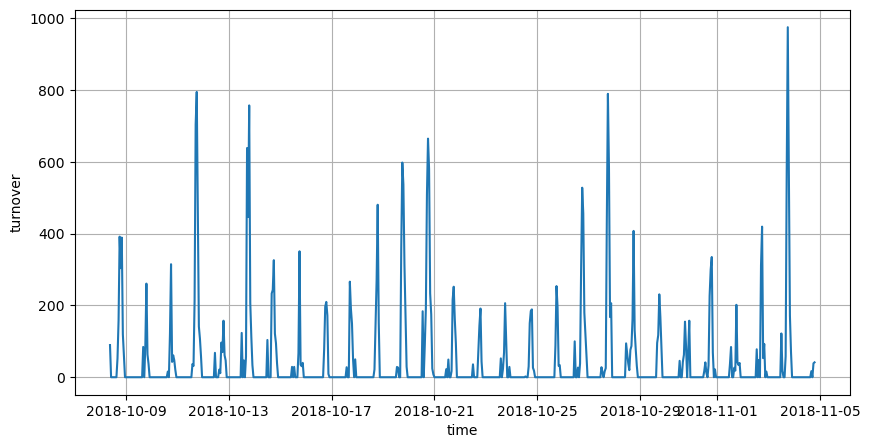

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
plt.plot(df.order_date, df.cash_in)
plt.xlabel("time")
plt.ylabel("turnover")
plt.grid(True)